In [1]:
import tensorflow as tf
import numpy as np 
import matplotlib.pyplot as plt
from sklearn import metrics, utils
import pandas as pd
import seaborn as sns
import cv2
from PIL import Image
import os

In [2]:
train_data = pd.read_csv("Train.csv")
test_data = pd.read_csv("Train.csv")

train_data.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


Number of different Classes:  43


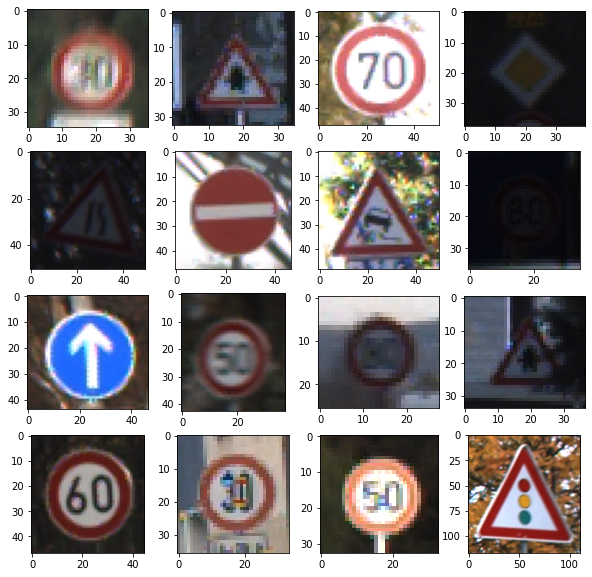

In [3]:
class_type = train_data['ClassId'].nunique()
print("Number of different Classes: ", class_type)

img_src = train_data["Path"]
num_rows = train_data['ClassId'].count()

sample = plt.subplots(4,4, figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    ind = np.random.randint(num_rows)
    plt.imshow(plt.imread(img_src[ind]))
#     plt.imshow(plt.imread(train_data["Path"][np.random.randint(num_rows)]))

plt.show()

In [4]:
train_data['ClassId']=train_data['ClassId'].astype('str')
train_data = pd.concat([train_data['Path'], train_data['ClassId']], axis = 1)
train_data = utils.shuffle(train_data)
train_data.head()


,Path,ClassId
30927,Train/28/00028_00003_00027.png,28
31533,Train/29/00029_00006_00003.png,29
10155,Train/5/00005_00057_00015.png,5
13193,Train/8/00008_00034_00023.png,8
153,Train/20/00020_00005_00003.png,20


Found 31368 validated image filenames belonging to 43 classes.
Found 7841 validated image filenames belonging to 43 classes.
(70, 40, 40, 3)


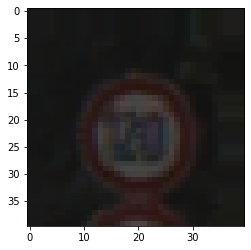

In [5]:
BATCH_SIZE = 70
IMG_SIZE = (40, 40)

imageValidation_Gen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range = 0,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.15,
    zoom_range = 0.15,
    rescale = 1/255.0,
    horizontal_flip=False,
    vertical_flip=False,
    validation_split= 0.2,
    fill_mode = 'nearest'
)

trainData_gen = imageValidation_Gen.flow_from_dataframe(
    train_data,
    directory="",
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    subset="training",
)

val_gen = imageValidation_Gen.flow_from_dataframe(
    train_data,
    directory="",
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    subset="validation",
)

gen = next(trainData_gen)
print(gen[0].shape)
plt.imshow(gen[0][0,:,:,:])

In [7]:
classifier = tf.keras.models.Sequential([    
    tf.keras.layers.Conv2D(8, (3,3), activation='relu', input_shape=(40,40, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.AveragePooling2D(),
    tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
#     tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.3),
    
#using softmax as activation function instead of relu as it is a multiclass classification problem
    tf.keras.layers.Dense(class_type, activation='softmax') 
])

tf.keras.utils.plot_model (classifier, to_file = 'trained_classifier.png', 
                           show_shapes = True)

classifier.compile(
    loss = 'categorical_crossentropy', 
    optimizer = 'adam',
    metrics = ['accuracy']
)

print(classifier.summary())


('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 38, 38, 8)         224       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 36, 36, 16)        1168      
_________________________________________________________________
average_pooling2d_2 (Average (None, 18, 18, 16)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 18, 18, 16)        64        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 32)        4640      
_________________________________________________________________
conv2d_7 (Conv2D

In [8]:
history = classifier.fit(x = trainData_gen,
                         epochs = 15,
                         validation_data = val_gen,
                         verbose = True
                        )

Epoch 1/15
449/449 [==============================] - 418s 929ms/step - loss: 1.1080 - accuracy: 0.6847 - val_loss: 1.3119 - val_accuracy: 0.6189
Epoch 2/15
449/449 [==============================] - 95s 212ms/step - loss: 0.2222 - accuracy: 0.9291 - val_loss: 0.1649 - val_accuracy: 0.9464
Epoch 3/15
449/449 [==============================] - 94s 210ms/step - loss: 0.1231 - accuracy: 0.9610 - val_loss: 0.1155 - val_accuracy: 0.9631
Epoch 4/15
449/449 [==============================] - 94s 210ms/step - loss: 0.0927 - accuracy: 0.9704 - val_loss: 0.0998 - val_accuracy: 0.9682
Epoch 5/15
449/449 [==============================] - 94s 210ms/step - loss: 0.0679 - accuracy: 0.9782 - val_loss: 0.0718 - val_accuracy: 0.9770
Epoch 6/15
449/449 [==============================] - 94s 210ms/step - loss: 0.0581 - accuracy: 0.9814 - val_loss: 0.0522 - val_accuracy: 0.9842
Epoch 7/15
449/449 [==============================] - 95s 211ms/step - loss: 0.0464 - accuracy: 0.9859 - val_loss: 0.4815 - val_a

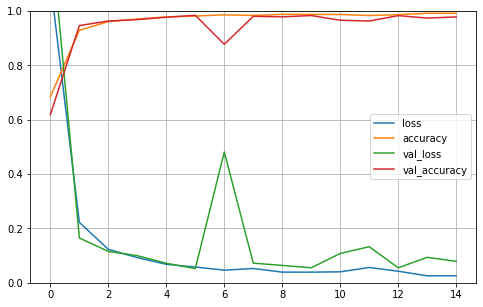

In [9]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [11]:
test_data['ClassId'] = test_data['ClassId'].astype('str')

test_gen = imageValidation_Gen.flow_from_dataframe(
    test_data,
    directory="",
    x_col='Path',
    y_col='ClassId',
    target_size=IMG_SIZE,
    color_mode="rgb",
    batch_size=BATCH_SIZE,
)

classifier.evaluate(test_gen)


Found 39209 validated image filenames belonging to 43 classes.
561/561 [==============================] - 84s 150ms/step - loss: 0.0680 - accuracy: 0.9802


[0.06799239665269852, 0.9802341461181641]